<h4>Introduction to Neural Network Classification with TensorFlow</h4>
<ul>
    <li>Binary Classification</li>
    <li>Multiclass Classification</li>
     <li>Multilabel Classification</li>
</ul>

<h5>Importing the data and Feature Engineering</h5>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import sqlite3
import datetime
import matplotlib.pyplot as plt
import scipy.stats as stats

print("tf.__version__")

# Forex
class Forex(object):
    def __init__(self, ticker: str, time_frame: str):
        self.ticker = ticker
        self.time_frame = time_frame

    def load_data(ticker: str, time_frame: str): # Load dataset.
        params_dic = {
         'host': 'localhost',
         'database': '/home/felipe/Desktop/python/projects/algorithmic-trading/data/forex.db'
        }
        with sqlite3.connect(f"{params_dic['database']}") as connection:
            dataset = pd.read_sql_query("SELECT * FROM "+ticker.lower()+"_"+time_frame, connection)
            return dataset

# Feature Engineering
class FeatureEngineering(Forex):
    def __init__(self, ticker: str, time_frame: str):
        super().__init__(ticker, time_frame)

    def load_features(self): # Load features
        dataset = Forex.load_data(self.ticker, self.time_frame).dropna()
        dataset.index = dataset['date']
        dataset['date'] = pd.to_datetime(dataset['date'])
        dataset['weekday'] = datetime.datetime.today().weekday()
        dataset['absolute_differences'] = dataset['close'].diff()
        dataset['normalize'] = dataset['close'] / dataset['close'].iloc[0]
        dataset['min_21'] = dataset['close'].rolling(window=21).min()
        dataset['max_21'] = dataset['close'].rolling(window=21).max()
        dataset['std_21'] = dataset['close'].rolling(window=21).std()
        dataset['sma_21'] = dataset['close'].rolling(window=21).mean()
        dataset['ema_21'] = dataset['close'].ewm(com=21, min_periods=21).mean()
        dataset['ema_55'] = dataset['close'].ewm(com=55, min_periods=55).mean()
        for lag in range(1, 4): 
            dataset[f'daily_return_{lag}'] = dataset['close'].pct_change(lag)
        return pd.DataFrame(dataset.dropna())

# Strategy EMA
class StrategyEMA(Forex):
    def __init__(self, ticker: str, time_frame: str):
        super().__init__(ticker, time_frame)

    def load_features(self): # Load features
        dataset = Forex.load_data(self.ticker, self.time_frame)
        dataset.index = dataset['date']
        dataset['date'] = pd.to_datetime(dataset['date'])
        dataset['ema_8'] = dataset['close'].ewm(com=8, min_periods=21).mean()
        dataset['ema_21'] = dataset['close'].ewm(com=21, min_periods=21).mean()
        dataset['position'] = np.where((dataset['ema_21'] <= dataset['close']) & (dataset['ema_8'] <= dataset['close']) & (dataset['ema_21'] <= dataset['ema_8']), 1, -1)
        dataset.dropna(inplace=True)
        return dataset

# Strategy RSI
class StrategyRSI(Forex):
    def __init__(self, ticker: str, time_frame: str):
        super().__init__(ticker, time_frame)

    # RSI
    def rsi(self, dataset, period) -> int:
        delta = dataset.diff().dropna()
        u = delta * 0
        d = u.copy()
        u[delta > 0] = delta[delta > 0]
        d[delta < 0] = -delta[delta < 0]
        u[u.index[period-1]] = np.mean(u[:period]) #first value is sum of avg gains
        u = u.drop(u.index[:(period-1)])
        d[d.index[period-1]] = np.mean(d[:period]) #first value is sum of avg losses
        d = d.drop(d.index[:(period-1)])
        rs = u.ewm(com=period-1, adjust=False).mean() / d.ewm(com=period-1, adjust=False).mean()
        return 100 - 100 / (1 + rs)

    def load_features(self): # Load features
        dataset = Forex.load_data(self.ticker, self.time_frame)
        dataset.index = dataset['date']
        dataset['date'] = pd.to_datetime(dataset['date'])
        dataset['ema_8'] = dataset['close'].ewm(com=8, min_periods=21).mean()
        dataset['rsi13'] = self.rsi(dataset['ema_8'], 13)
        dataset['rsi21'] = self.rsi(dataset['ema_8'], 21)
        dataset['zscore'] = stats.zscore(dataset['close'])
        dataset['position'] = np.select([dataset['rsi21'] > 70, dataset['rsi21'] < 30, (dataset['rsi21'] > 30) & (dataset['rsi21'] < 70)], [-1, 1, 0])
        dataset.dropna(inplace=True)
        return dataset

if __name__ == '__main__':
    currency_pair = ['EURUSD']
    # currency_pair = ['AUDCAD', 'AUDNZD', 'AUDUSD', 'CADCHF', 'EURAUD', 'EURBRL', 'EURCAD', 'EURCHF', 'EURHUF', 'EURGBP', 'EURJPY', 'EURNZD', 'EURUSD', 'GBPCAD', 'GBPCHF', 'GBPJPY', 'GBPUSD', 'GBPNZD', 'USDCAD', 'USDCHF', 'USDJPY', 'USDMXN', 'USDSGD', 'USDTRY', 'NZDCAD', 'NZDUSD', 'NZDJPY']
    for currency in currency_pair:
        # time_frames = ['1d', '1wk', '1mo', '3mo'] # Intervals: “1m”, “2m”, “5m”, “15m”, “30m”, “60m”, “90m”, “1h”, “1d”, “5d”, “1wk”, “1mo”, “3mo”
        time_frames = ['1d']
        for time_frame in time_frames:
            # dataset = StrategyEMA(currency, time_frame).load_features()
            dataset = StrategyRSI(currency, time_frame).load_features()
    print(dataset.info(), '\n', dataset['position'].value_counts(), '\n', dataset.describe)


2022-04-19 23:01:13.622843: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-19 23:01:13.622882: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


tf.__version__
<class 'pandas.core.frame.DataFrame'>
Index: 4726 entries, 2021-09-03 00:00:00 to 2022-04-16 00:00:00
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      4726 non-null   datetime64[ns]
 1   open      4726 non-null   float64       
 2   high      4726 non-null   float64       
 3   low       4726 non-null   float64       
 4   close     4726 non-null   float64       
 5   ema_8     4726 non-null   float64       
 6   rsi13     4726 non-null   float64       
 7   rsi21     4726 non-null   float64       
 8   zscore    4726 non-null   float64       
 9   position  4726 non-null   int64         
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 406.1+ KB
None 
  0    1879
 1    1429
-1    1418
Name: position, dtype: int64 
 <bound method NDFrame.describe of                           date      open      high       low     close  \
date                                           

<h4>Create Neural Network - Classification</h6>
<ul>
    <li>Create a model (define the input and output layers, as well as the hidden layers.)</li>
    <li>Compile a model (define the loss function and the optimizer and evaluate the metrics.)</li>
    <li>Fitting a model</li>
</ul>

(4726, 1) 

<class 'numpy.ndarray'> 4726
(4726,) 

<class 'numpy.ndarray'> 4726
[1 0 0 ... 1 1 1] 

x_train: (3780, 1), y_train:(3780,), <class 'tensorflow.python.framework.ops.EagerTensor'>, <dtype: 'float16'> 

x_test: (946, 1), y_test:(946,), <class 'tensorflow.python.framework.ops.EagerTensor'>, <dtype: 'float16'> 

Epoch 1/20
119/119 [==============================] - 1s 876us/step - loss: nan - accuracy: 0.3942
Epoch 2/20
119/119 [==============================] - 0s 937us/step - loss: nan - accuracy: 0.3942
Epoch 3/20
119/119 [==============================] - 0s 954us/step - loss: nan - accuracy: 0.3942
Epoch 4/20
119/119 [==============================] - 0s 947us/step - loss: nan - accuracy: 0.3942
Epoch 5/20
119/119 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.3942
Epoch 6/20
119/119 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.3942
Epoch 7/20
119/119 [==============================] - 0s 1ms/step - loss: nan - accuracy

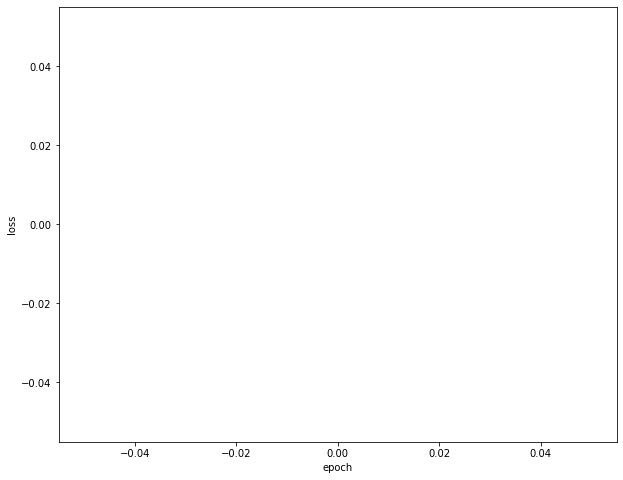

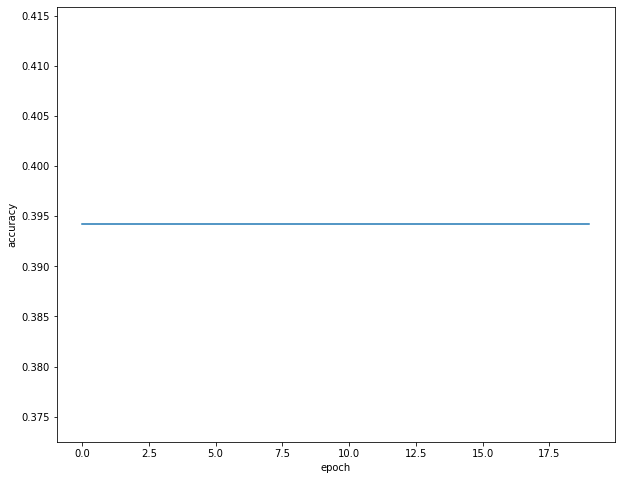

y_prediction: (946, 1), <class 'numpy.ndarray'> 



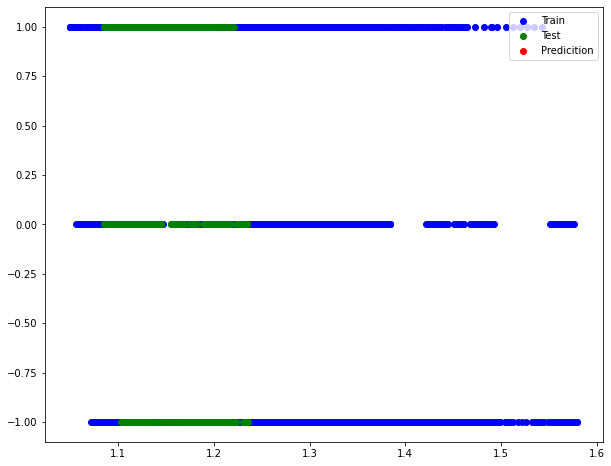

30/30 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.4112
Model_evaluate: [nan, 0.41120508313179016]


In [6]:
# Create a feature
#x = tf.constant(dataset.loc[:, ~dataset.columns.isin(['close']])], dtype=tf.float32)
x = np.array(dataset.loc[:, dataset.columns.isin(['ema_8'])])
print(x.shape, '\n')
print(type(x), len(x))
#print(x, '\n')

# Create a label
y = np.array(dataset['position'])
print(y.shape, '\n')
print(type(y), len(y))
print(y, '\n')

# Split train and test (3 Sets)
percent_index = int(0.80 * len(x))
x_train, x_test = tf.constant(x[:percent_index], dtype=tf.float16), tf.constant(x[percent_index:], dtype=tf.float16)
y_train, y_test = tf.constant(y[:percent_index], dtype=tf.float16), tf.constant(y[percent_index:], dtype=tf.float16)
print(f'x_train: {x_train.shape}, y_train:{y_train.shape}, {type(y_train)}, {y_train.dtype} \n')
print(f'x_test: {x_test.shape}, y_test:{y_test.shape}, {type(y_train)}, {y_test.dtype} \n')
#print(x_test, '\n')

# Create a model (define the input and output layers, as well as the hidden layers.)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(100, activation='relu', input_shape=(x_train.shape[1],)))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile a model (define the loss function and the optimizer and evaluate the metrics.)
model.compile(optimizer=tf.keras.optimizers.SGD(), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
#print(f'Summary:\n {model.summary()}', '\n')

# Fitting a model
history = model.fit(x_train, y_train, epochs=20)
print(history.model)

# Visualize Metrics
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()   
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Predict using model and last parameters ('close' to discover 'position')
#y_prediction = model.predict([[dataset['close'][-1]]])
#print(y_prediction, '\n')

# Predict using model and x_test
y_prediction = model.predict(x_test)
print(f'y_prediction: {y_prediction.shape}, {type(y_prediction)}', '\n')
#print(f'y_prediction: {y_prediction}')

# Predict using model ('close', 'position' to discover 'daily_return_1')
def plot_prediction(train_data=x_train, train_label=y_train, test_data=x_test, test_label=y_test, y_prediction=y_prediction):
    plt.figure(figsize=(10, 8))
    plt.scatter(train_data, train_label, c='b', label='Train')
    plt.scatter(test_data, test_label, c='g', label='Test')
    plt.scatter(test_data, y_prediction, c='r', label='Predicition')
    plt.legend()
    plt.show()
plot_prediction()

# Model_evaluate
print(f'Model_evaluate: {model.evaluate(x_test, y_test)}')

